# Programming Assignment

## Saving and loading models, with application to the EuroSat dataset

### Instructions

In this notebook, you will create a neural network that classifies land uses and land covers from satellite imagery. You will save your model using Tensorflow's callbacks and reload it later. You will also load in a pre-trained neural network classifier and compare performance with it.

Some code cells are provided for you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line:

`#### GRADED CELL ####`

Don't move or edit this first line - this is what the automatic grader looks for to recognise graded cells. These cells require you to write your own code to complete them, and are automatically graded when you submit the notebook. Don't edit the function name or signature provided in these cells, otherwise the automatic grader might not function properly. Inside these graded cells, you can use any functions or classes that are imported below, but make sure you don't use any variables that are outside the scope of the function.

### How to submit

Complete all the tasks you are asked for in the worksheet. When you have finished and are happy with your code, press the **Submit Assignment** button at the top of this notebook.

### Let's get started!

We'll start running some imports, and loading the dataset. Do not edit the existing imports in the following cell. If you would like to make further Tensorflow imports, you should add them here.

In [ ]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import numpy as np
import pandas as pd

# If you would like to make further imports from tensorflow, add them here
from pathlib import Path
import matplotlib.pyplot as plt


2025-11-27 10:32:07.350140: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 10:32:07.395828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764261127.434882   24515 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764261127.444210   24515 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764261127.478826   24515 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Import the data

#### The EuroSAT dataset

In this assignment, you will use the [EuroSAT dataset](https://github.com/phelber/EuroSAT). It consists of 27000 labelled Sentinel-2 satellite images of different land uses: residential, industrial, highway, river, forest, pasture, herbaceous vegetation, annual crop, permanent crop and sea/lake. For a reference, see the following papers:
- Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.
- Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018.

Your goal is to construct a neural network that classifies a satellite image into one of these 10 classes, as well as applying some of the saving and loading techniques you have learned in the previous sessions.

#### Import the data

The dataset you will train your model on is a subset of the total data, with 4000 training images and 1000 testing images, with roughly equal numbers of each class.
The train and test datasets required for this project can be downloaded from the following links:

`x_train`: https://drive.google.com/open?id=1cUaIEd9-MLJHFGjLz5QziNvfBtYygplX

`y_train`: https://drive.google.com/open?id=1hv24Ufiio9rBeSqgnNoM3dr5sVGwOmBy

`x_test`: https://drive.google.com/open?id=1AH9lKHT5P2oQLz8SGMRPWs_M9wIM2ZRH

`y_test`: https://drive.google.com/open?id=1i4_azocSDuU3TcDf3OSHO1vF0D5-xMU6

You should store these files in Drive for use in this Colab notebook.

In [2]:
# create the new folder weekly_data and download the data from the link provided in the instructions
!mkdir -p weekly_data
!wget -P weekly_data/ https://zenodo.org/api/records/7711810/files-archive

--2025-11-27 08:44:12--  https://zenodo.org/api/records/7711810/files-archive
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 137.138.52.235, 188.185.43.153, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘weekly_data/files-archive’

files-archive           [  <=>               ]   2.01G  1.56MB/s    in 35m 42s 

2025-11-27 09:19:59 (985 KB/s) - ‘weekly_data/files-archive’ saved [2160061446]



In [6]:
!mv weekly_data/files-archive weekly_data/files-archive.zip

In [7]:
zip_path = "weekly_data/files-archive.zip"

In [3]:
# add the folder to gitignore
!echo "weekly_data/" >> .gitignore

In [ ]:
!unzip -l weekly_data/files-archive.zip | head -40

/bin/bash: line 1: unzip: command not found


In [10]:
import zipfile

zip_path = "weekly_data/files-archive.zip"  # or "weekly_data/files-archive.zip"

with zipfile.ZipFile(zip_path, "r") as zf:
    files = zf.namelist()
    print("Number of entries:", len(files))
    for name in files[:40]:
        print(name)

Number of entries: 2
EuroSAT_MS.zip
EuroSAT_RGB.zip


In [11]:
import zipfile
from pathlib import Path

outer_zip = Path("weekly_data/files-archive.zip")  # or .zip if you renamed it
output_dir = Path("weekly_data")
output_dir.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(outer_zip, "r") as zf:
    # Extract only the RGB version
    zf.extract("EuroSAT_RGB.zip", path=output_dir)
    # If you also want MS:
    # zf.extract("EuroSAT_MS.zip", path=output_dir)

print((output_dir / "EuroSAT_RGB.zip").exists())  # should be True


True


In [16]:
inner_zip = output_dir / "EuroSAT_RGB.zip"
rgb_dir = output_dir / "EuroSAT_RGB"
rgb_dir.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(inner_zip, "r") as zf:
    zf.extractall(rgb_dir)

print("Extracted to:", rgb_dir)

Extracted to: weekly_data/EuroSAT_RGB


In [19]:
# view all the new files in the folder
!ls -lR weekly_data /EuroSAT_RGB | head -40

ls: cannot access '/EuroSAT_RGB': No such file or directory
weekly_data:
total 2201888
drwxr-xr-x 3 nvidia nvidia       4096 Nov 27 09:43 EuroSAT_RGB
-rw-r--r-- 1 nvidia nvidia   94658721 Nov 27 09:43 EuroSAT_RGB.zip
-rw-r--r-- 1 nvidia nvidia 2160061446 Nov 27 09:19 files-archive.zip

weekly_data/EuroSAT_RGB:
total 4
drwxr-xr-x 12 nvidia nvidia 4096 Nov 27 09:43 EuroSAT_RGB

weekly_data/EuroSAT_RGB/EuroSAT_RGB:
total 1168
drwxr-xr-x 2 nvidia nvidia 126976 Nov 27 09:43 AnnualCrop
drwxr-xr-x 2 nvidia nvidia 118784 Nov 27 09:43 Forest
drwxr-xr-x 2 nvidia nvidia 176128 Nov 27 09:43 HerbaceousVegetation
drwxr-xr-x 2 nvidia nvidia  94208 Nov 27 09:43 Highway
drwxr-xr-x 2 nvidia nvidia 110592 Nov 27 09:43 Industrial
drwxr-xr-x 2 nvidia nvidia  69632 Nov 27 09:43 Pasture
drwxr-xr-x 2 nvidia nvidia 131072 Nov 27 09:43 PermanentCrop
drwxr-xr-x 2 nvidia nvidia 135168 Nov 27 09:43 Residential
drwxr-xr-x 2 nvidia nvidia  81920 Nov 27 09:43 River
drwxr-xr-x 2 nvidia nvidia 118784 Nov 27 09:43 SeaLa

# Load the Data

In [2]:
def load_eurosat_data(
    data_root="weekly_data/EuroSAT_RGB/EuroSAT_RGB",
    image_size=(64, 64),
    batch_size=32,
    fraction=0.05,      # 0.05 = use 5% of images; set to 1.0 for all
    seed=1337,
):
    """
    Returns (x_train, y_train), (x_test, y_test) as NumPy arrays
    built from the EuroSAT RGB directory structure.
    """

    data_root = Path(data_root)

    # 1) Build TF datasets from directory (80% train, 20% "test")
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_root,
        validation_split=0.2,
        subset="training",
        seed=seed,
        image_size=image_size,
        batch_size=batch_size,
        label_mode="int",
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        data_root,
        validation_split=0.2,
        subset="validation",
        seed=seed,
        image_size=image_size,
        batch_size=batch_size,
        label_mode="int",
    )

    # 2) Optionally reduce to a fraction (e.g. 5%) of the images
    if fraction is not None and fraction < 1.0:
        # Estimate total number of examples from number of batches * batch_size
        n_train_batches = tf.data.experimental.cardinality(train_ds).numpy()
        n_test_batches  = tf.data.experimental.cardinality(test_ds).numpy()

        n_train = n_train_batches * batch_size
        n_test  = n_test_batches * batch_size

        n_train_small = int(n_train * fraction)
        n_test_small  = int(n_test * fraction)

        train_ds = train_ds.unbatch().take(n_train_small).batch(batch_size)
        test_ds  = test_ds.unbatch().take(n_test_small).batch(batch_size)

    # 3) Convert tf.data.Dataset → NumPy arrays
    def ds_to_numpy(ds):
        xs, ys = [], []
        for x_batch, y_batch in ds:
            xs.append(x_batch.numpy())
            ys.append(y_batch.numpy())
        x = np.concatenate(xs, axis=0)
        y = np.concatenate(ys, axis=0)
        return x, y

    x_train, y_train = ds_to_numpy(train_ds)
    x_test, y_test   = ds_to_numpy(test_ds)

    return (x_train, y_train), (x_test, y_test)


In [3]:
(x_train, y_train), (x_test, y_test) = load_eurosat_data()

# scale pixels to [0, 1]
x_train = x_train / 255.0
x_test  = x_test  / 255.0

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


Found 27000 files belonging to 10 classes.
Using 21600 files for training.


I0000 00:00:1764261135.988316   24515 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 27000 files belonging to 10 classes.
Using 5400 files for validation.
(1080, 64, 64, 3) (1080,)
(270, 64, 64, 3) (270,)


2025-11-27 10:32:20.697190: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-27 10:32:20.749870: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [174]:

DATA_ROOT = Path("weekly_data") / "EuroSAT_RGB" / "EuroSAT_RGB"

tmp_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT,
    image_size=(64, 64),
    batch_size=32,
    shuffle=False,        # order doesn't matter here
    label_mode="int",
)

class_names = tmp_ds.class_names
print("Class names:", class_names)


Found 27000 files belonging to 10 classes.
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [175]:
def decode_label(idx):
    idx = int(idx)
    return class_names[idx]

print(y_test[0], decode_label(y_test[0]))
# e.g. "5 Pasture"

unique_labels = sorted(set(y_test))
for i in unique_labels:
    print(i, "→", decode_label(i))


0 AnnualCrop
0 → AnnualCrop
1 → Forest
2 → HerbaceousVegetation
3 → Highway
4 → Industrial
5 → Pasture
6 → PermanentCrop
7 → Residential
8 → River
9 → SeaLake


Label: 7


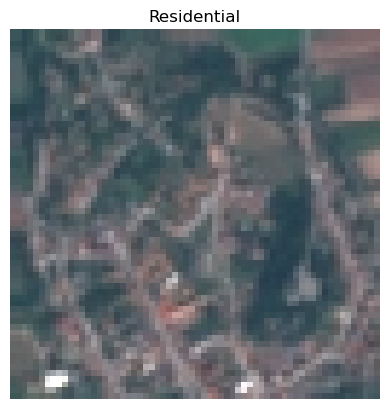

In [178]:

# pick one test image
idx = np.random.randint(0, x_test.shape[0])
img = x_test[idx]          # shape (64, 64, 3)
label = y_test[idx]

print("Label:", label)
plt.imshow(img)
plt.axis("off")
plt.title(decode_label(label))
plt.show()


# Build the neural network model

You can now construct a model to fit to the data. Using the Sequential API, build your model according to the following specifications:

* The model should use the input_shape in the function argument to set the input size in the first layer.
* The first layer should be a Conv2D layer with 16 filters, a 3x3 kernel size, a ReLU activation function and 'SAME' padding. Name this layer 'conv_1'.
* The second layer should also be a Conv2D layer with 8 filters, a 3x3 kernel size, a ReLU activation function and 'SAME' padding. Name this layer 'conv_2'.
* The third layer should be a MaxPooling2D layer with a pooling window size of 8x8. Name this layer 'pool_1'.
* The fourth layer should be a Flatten layer, named 'flatten'.
* The fifth layer should be a Dense layer with 32 units, a ReLU activation. Name this layer 'dense_1'.
* The sixth and final layer should be a Dense layer with 10 units and softmax activation. Name this layer 'dense_2'.

In total, the network should have 6 layers.

In [85]:
#### GRADED CELL ####

# Complete the following function.
# Make sure to not change the function name or arguments.

def get_new_model(input_shape):
    """
    This function should build a Sequential model according to the above specification. Ensure the
    weights are initialised by providing the input_shape argument in the first layer, given by the
    function argument.
    Your function should also compile the model with the Adam optimiser, sparse categorical cross
    entropy loss function, and a single accuracy metric.
    """

    model = tf.keras.Sequential()

    # 1) Conv2D, 16 filters, 3x3, ReLU, SAME padding
    model.add(Conv2D(
            filters=16,
            kernel_size=(3, 3),
            activation="relu",
            padding="same",
            input_shape=input_shape,
            name="conv_1",
        ))
    
    # 2) Conv2D, 8 filters, 3x3, ReLU, SAME padding
    model.add(Conv2D(
            filters=8,
            kernel_size=(3, 3),
            activation="relu",
            padding="same",
            name="conv_2",
        ))
    
    # 3) MaxPooling2D, 8x8
    model.add(MaxPooling2D(pool_size=(8, 8), name="pool_1"))
    
    # 4) Flatten
    model.add(Flatten(name="flatten"))
    
    # 5) Dense, 32 units, ReLU
    model.add(Dense(32, activation="relu", name="dense_1"))
    
    # 6) Dense, 10 units, softmax
    model.add(Dense(10, activation="softmax", name="dense_2"))

    # Compile with Adam, sparse categorical crossentropy, accuracy
    optimizer = tf.keras.optimizers.Adam()
    loss = 'sparse_categorical_crossentropy'
    metrics = ['accuracy']

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )

    return model

#### Compile and evaluate the model

In [86]:
# Run your function to create the model

model = get_new_model(x_train[0].shape)
    
model.summary()

/home/nvidia/miniforge3/envs/rapids-25.10-cuda12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,354 (71.70 KB)

 Trainable params: 18,354 (71.70 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
# Run this cell to define a function to evaluate a model's test accuracy

def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [89]:
# Print the model summary and calculate its initialised test accuracy

get_test_accuracy(model, x_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.1259 - loss: 2.2887
accuracy: 0.126


# Create checkpoints to save model during training, with a criterion

You will now create three callbacks:
- `checkpoint_every_epoch`: checkpoint that saves the model weights every epoch during training
- `checkpoint_best_only`: checkpoint that saves only the weights with the highest validation accuracy. Use the testing data as the validation data.
- `early_stopping`: early stopping object that ends training if the validation accuracy has not improved in 3 epochs.

In [63]:
#### GRADED CELL ####

# Complete the following functions.
# Make sure to not change the function names or arguments.

import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def get_checkpoint_every_epoch():
    """
    This function should return a ModelCheckpoint object that:
    - saves the full model at the end of every epoch
    - saves into a directory called 'checkpoints_every_epoch' inside the current working directory
    - generates filenames in that directory like 'checkpoint_XXX.keras'
      where XXX is the epoch number formatted to have three digits, e.g. 001, 002, 003, etc.
    """
    os.makedirs("checkpoints_every_epoch", exist_ok=True)
    filepath = os.path.join("checkpoints_every_epoch", "checkpoint_{epoch:03d}.keras")

    checkpoint = ModelCheckpoint(
        filepath=filepath,
        save_weights_only=False,   # full model
        save_best_only=False,
        save_freq="epoch",
        verbose=0,
    )
    return checkpoint


def get_checkpoint_best_only():
    """
    This function should return a ModelCheckpoint object that:
    - saves only the full model that generates the highest validation (testing) accuracy
    - saves into a directory called 'checkpoints_best_only' inside the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint.keras'
    """
    os.makedirs("checkpoints_best_only", exist_ok=True)
    filepath = os.path.join("checkpoints_best_only", "checkpoint.keras")

    checkpoint = ModelCheckpoint(
        filepath=filepath,
        save_weights_only=False,   # full model
        save_best_only=True,
        monitor="val_accuracy",
        mode="max",
        verbose=0,
    )
    return checkpoint


In [64]:
#### GRADED CELL ####

# Complete the following function.
# Make sure to not change the function name or arguments.

def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last 3 epochs.
    HINT: use the EarlyStopping callback with the correct 'monitor' and 'patience'
    """
    early_stopping = EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        verbose=0,
    )
    return early_stopping


In [65]:
# Run this cell to create the callbacks

checkpoint_every_epoch = get_checkpoint_every_epoch()
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()

# Train model using the callbacks

Now, you will train the model using the three callbacks you created. If you created the callbacks correctly, three things should happen:
- At the end of every epoch, the model weights are saved into a directory called `checkpoints_every_epoch`
- At the end of every epoch, the model weights are saved into a directory called `checkpoints_best_only` **only** if those weights lead to the highest test accuracy
- Training stops when the testing accuracy has not improved in three epochs.

You should then have two directories:
- A directory called `checkpoints_every_epoch` containing filenames that include `checkpoint_001`, `checkpoint_002`, etc with the `001`, `002` corresponding to the epoch
- A directory called `checkpoints_best_only` containing filenames that include `checkpoint`, which contain only the weights leading to the highest testing accuracy

In [66]:
# Train model using the callbacks you just created

callbacks = [checkpoint_every_epoch, checkpoint_best_only, early_stopping]
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/50


34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.0935 - loss: 2.2572 - val_accuracy: 0.1111 - val_loss: 2.2000
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2019 - loss: 2.1325 - val_accuracy: 0.2148 - val_loss: 2.0528
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3380 - loss: 1.9021 - val_accuracy: 0.3444 - val_loss: 1.7208
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3602 - loss: 1.6320 - val_accuracy: 0.3481 - val_loss: 1.6367
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4250 - loss: 1.4557 - val_accuracy: 0.4741 - val_loss: 1.4340
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4704 - loss: 1.3466 - val_accuracy: 0.4185 - val_loss: 1.3949
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5194 - loss: 1.2770 - val_accuracy: 0.5259 - val_loss: 1.2786
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5481 - loss: 1.2098 - val_accuracy: 0.5444 - val_loss: 1.2

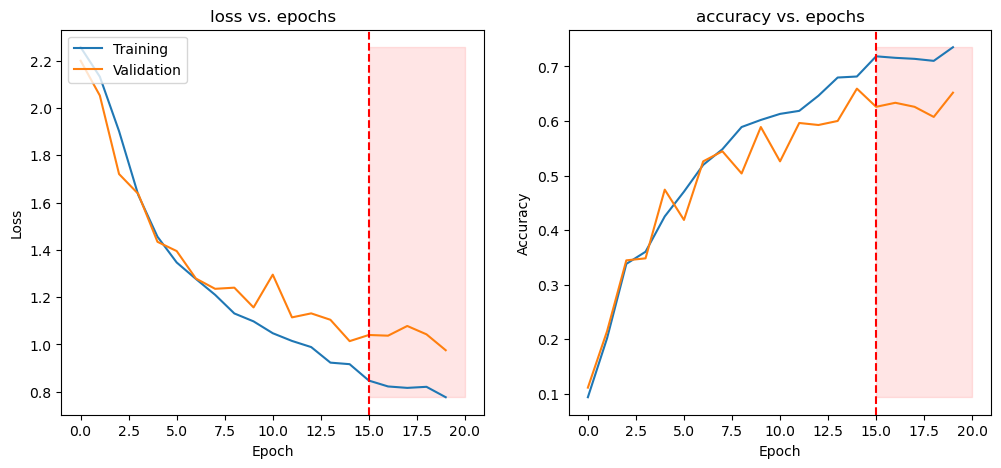

In [67]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

patience = 5
plt.axvline(x=len(history.history['loss'])-patience, color='r', linestyle='--')
plt.fill_betweenx(
    y=[min(min(history.history['loss']), min(history.history['val_loss'])), 
       max(max(history.history['loss']), max(history.history['val_loss']))],
    x1=len(history.history['loss'])-patience,
    x2=len(history.history['loss']),
    color='red',
    alpha=0.1
)

plt.legend(['Training', 'Validation'], loc='upper left')

fig.add_subplot(122)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.axvline(x=len(history.history['accuracy'])-patience, color='r', linestyle='--')
plt.fill_betweenx(
    y=[min(min(history.history['accuracy']), min(history.history['val_accuracy'])), 
       max(max(history.history['accuracy']), max(history.history['val_accuracy']))],
    x1=len(history.history['accuracy'])-patience,
    x2=len(history.history['accuracy']),
    color='red',
    alpha=0.1
)

plt.show()

# Create new instance of model and load on both sets of weights

Now you will use the weights you just saved in a fresh model. You should create two functions, both of which take a freshly instantiated model instance:
- `model_last_epoch` should contain the weights from the latest saved epoch
- `model_best_epoch` should contain the weights from the saved epoch with the highest testing accuracy

_Hint: use the_ `tf.train.latest_checkpoint` _function to get the filename of the latest saved checkpoint file. Check the docs_ [_here_](https://www.tensorflow.org/api_docs/python/tf/train/latest_checkpoint).

In [90]:
#### GRADED CELL ####

# Complete the following functions.
# Make sure to not change the function name or arguments.

import glob
import tensorflow as tf

def get_model_last_epoch(model):
    """
    This function should create a new instance of the CNN you created earlier,
    load on the weights from the last training epoch, and return this model.
    
    Here we instead load the full saved model from the latest .keras file.
    """
    ckpt_dir = "checkpoints_every_epoch"
    pattern = os.path.join(ckpt_dir, "checkpoint_*.keras")
    files = glob.glob(pattern)
    if not files:
        raise FileNotFoundError("No checkpoints found in 'checkpoints_every_epoch'.")

    # Because of checkpoint_{epoch:03d}.keras, max() gives the highest epoch number
    latest_ckpt = max(files)

    loaded_model = tf.keras.models.load_model(latest_ckpt)
    return loaded_model


def get_model_best_epoch(model):
    """
    This function should create a new instance of the CNN you created earlier, load
    on the weights leading to the highest validation accuracy, and return this model.
    
    Here we load the full saved best model from 'checkpoints_best_only/checkpoint.keras'.
    """
    best_ckpt_path = os.path.join("checkpoints_best_only", "checkpoint.keras")
    if not os.path.exists(best_ckpt_path):
        raise FileNotFoundError("Best-checkpoint file not found at 'checkpoints_best_only/checkpoint.keras'.")

    loaded_model = tf.keras.models.load_model(best_ckpt_path)
    return loaded_model


In [91]:
# Run this cell to create two models: one with the weights from the last training
# epoch, and one wiht the weights leading to the highest validation (testing) accuracy.
# Verify that the second has a higher validation (testing) accuarcy.

model_last_epoch = get_model_last_epoch(get_new_model(x_train[0].shape))
model_best_epoch = get_model_best_epoch(get_new_model(x_train[0].shape))

print('Model with last epoch weights:')
get_test_accuracy(model_last_epoch, x_test, y_test)
print('')
print('Model with best epoch weights:')
get_test_accuracy(model_best_epoch, x_test, y_test)


Model with last epoch weights:
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6519 - loss: 0.9754
accuracy: 0.652

Model with best epoch weights:
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6593 - loss: 1.0139
accuracy: 0.659


# Visualize feature maps

In [92]:
model = model_best_epoch

In [124]:
def plot_kernels(model, layer=0, n_cols=4, figsize=(8, 8)):
    """
    This function plots the kernels of the first convolutional layer of the model.
    """
    conv_layer = model.layers[layer]              # or model.get_layer(index=layer)
    weights, biases = conv_layer.get_weights()

    print("weights.shape:", weights.shape)
    print("biases.shape:", biases.shape)

    kernels = weights  # shape: (3, 3, 1, 16)

    n_filters = kernels.shape[-1]

    # Get the highest and lowest values for normalizing the color scale
    vmin, vmax = kernels.min(), kernels.max()
    print("vmin:", vmin, "vmax:", vmax)
    # get the maximum of abs(vmin), abs(vmax)
    max_abs = max(abs(vmin), abs(vmax))
    vmin, vmax = -max_abs, max_abs
    print("Normalized vmin:", vmin, "vmax:", vmax)

    # Choose a grid size (e.g., 4x4 for 16 filters)
    n_cols = n_cols
    n_rows = int(np.ceil(n_filters / n_cols))
    cmap = 'berlin_r'
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    plt.figure(figsize=figsize)

    for i in range(n_filters):
        # kernel for filter i, shape: (3, 3, 1)
        k = kernels[:, :, 0, i]   # squeeze channel dimension → (3,3)
        
        ax = plt.subplot(n_rows, n_cols, i + 1)
        ax.imshow(k, interpolation='nearest', cmap=cmap, norm=norm)
        ax.set_title(f"Filter {i}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    print("Filter 0 weights:\n", kernels[:, :, 0, 0])
    print("\nFilter 1 weights:\n", kernels[:, :, 0, 1])
    print("\nFilter 5 weights:\n", kernels[:, :, 0, 5])

weights.shape: (3, 3, 3, 16)
biases.shape: (16,)
vmin: -0.27146628 vmax: 0.2860992
Normalized vmin: -0.2860992 vmax: 0.2860992


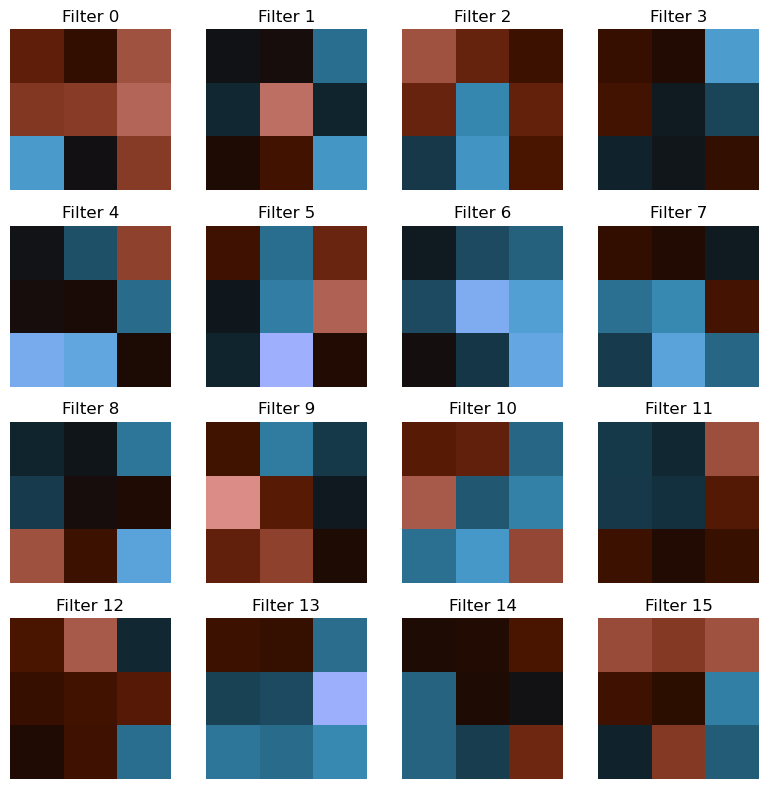

Filter 0 weights:
 [[-0.11256897 -0.04775592 -0.18183629]
 [-0.14950489 -0.15521188 -0.20355767]
 [ 0.20758717  0.01458229 -0.15275368]]

Filter 1 weights:
 [[ 0.01929483  0.00575689  0.15105097]
 [ 0.06025693 -0.21457791  0.05289364]
 [-0.01204492 -0.07393306  0.20029093]]

Filter 5 weights:
 [[-0.0711061   0.15096918 -0.12373707]
 [ 0.03073034  0.16823871 -0.19944046]
 [ 0.05229745  0.2860992  -0.02047727]]


In [ ]:
plot_kernels(model_best_epoch)

weights.shape: (3, 3, 16, 8)
biases.shape: (8,)
vmin: -0.33576784 vmax: 0.31693769
Normalized vmin: -0.33576784 vmax: 0.33576784


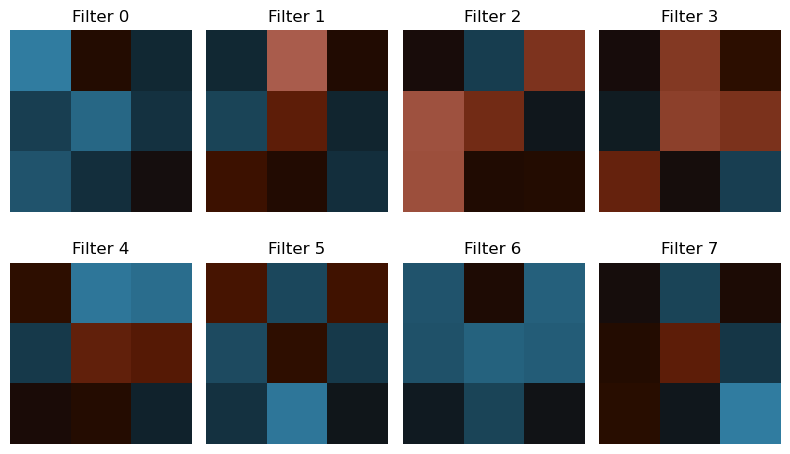

Filter 0 weights:
 [[ 0.19506662 -0.0263685   0.06868931]
 [ 0.10564945  0.16647537  0.08636483]
 [ 0.1369813   0.07926431  0.00850096]]

Filter 1 weights:
 [[ 0.07040355 -0.22666325 -0.02128227]
 [ 0.11340868 -0.12901725  0.06355263]
 [-0.07642414 -0.02617637  0.07948268]]

Filter 5 weights:
 [[-0.09597621  0.11818223 -0.08547247]
 [ 0.12381565 -0.05099907  0.09707978]
 [ 0.08510144  0.18736619  0.03262432]]


In [126]:
plot_kernels(model_best_epoch, layer=1, n_cols=4, figsize=(8, 5))

In [113]:
layer_names = ['conv_1', 'conv_2', 'pool_1']
outputs = [model.get_layer(name).output for name in layer_names]

activation_model = tf.keras.Model(
    inputs=model.layers[0].input,
    outputs=outputs,
)


In [114]:
img = x_test[0]
img_batch = np.expand_dims(img, 0)

act_conv1, act_conv2, act_pool1 = activation_model.predict(img_batch)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


In [ ]:
print("conv_1 feature maps:", act_conv1.shape)   # (1, 64, 64, 16)
print("conv_2 feature maps:", act_conv2.shape)   # (1, 64, 64, 8)
print("pool_1 feature maps:", act_pool1.shape)   # (1, 8, 8, 8)

conv_1 feature maps: (1, 64, 64, 16)
conv_2 feature maps: (1, 64, 64, 8)
pool_1 feature maps: (1, 8, 8, 8)


## Example

RGB makes the “channels” story a bit less intuitive at first.

Short version:

* The **input** has 3 channels (R, G, B).
* A Conv2D layer has many **filters** (e.g. 16).
* **Each filter uses all 3 color channels at once** and produces **1 output channel** (one feature map).
* So `conv_1` turns `(H, W, 3)` into `(H, W, 16)`. It is **not** “one channel per color”.



### How channels work with RGB images in Conv2D

#### 1. Input: RGB image

An RGB image has **3 channels**:

* Red (R)
* Green (G)
* Blue (B)

If the image is $64 \times 64$, the input shape is:

$$
x \in \mathbb{R}^{64 \times 64 \times 3}
$$

---

### 2. First convolution layer (`conv_1`)

You defined:

```python
Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu")
```

This layer has weights of shape:

$$
W^{(1)} \in \mathbb{R}^{3 \times 3 \times 3 \times 16}
$$

* $3 \times 3$: spatial size of the filter
* $3$: number of **input channels** (R, G, B)
* $16$: number of **filters** = number of **output channels**

For a **single filter** $k$ (one of those 16), the kernel is:

$$
W^{(1)}_{:,:,:,k} \in \mathbb{R}^{3 \times 3 \times 3}
$$

At each output pixel $(i,j)$, the convolution does:

$$
y^{(1)}_{i,j,k}
=

\sum_{u=1}^{3}
\sum_{v=1}^{3}
\sum_{c=1}^{3}
W^{(1)}*{u,v,c,k} ; x*{i+u-2,, j+v-2,, c}

* b^{(1)}_k
  $$

Key idea:

* The **sum over (c)** means the filter uses **all 3 color channels (R,G,B)** together.
* The result is **one scalar** at each ((i,j)), for this filter.

For one image, the output of `conv_1` has shape:

$$
y^{(1)} \in \mathbb{R}^{64 \times 64 \times 16}
$$

So:

* Input: 3 channels (RGB)
* Output: 16 channels (16 learned feature maps)

It is **not** “one channel per color per filter”; instead, each filter combines all 3 colors and outputs **one** new channel.

---

### 3. Second convolution layer (`conv_2`)

You defined:

```python
Conv2D(filters=8, kernel_size=(3,3), padding="same", activation="relu")
```

Now the **input** to this layer is the output of `conv_1`:

$$
y^{(1)} \in \mathbb{R}^{64 \times 64 \times 16}
$$

Weights:

$$
W^{(2)} \in \mathbb{R}^{3 \times 3 \times 16 \times 8}
$$

* (16): number of **input channels** (the 16 feature maps from `conv_1`)
* (8): number of **filters** = number of **output channels**

For a filter $k$ in `conv_2`:

$$
y^{(2)}_{i,j,k}
=

\sum_{u=1}^{3}
\sum_{v=1}^{3}
\sum_{c=1}^{16}
W^{(2)}*{u,v,c,k} ; y^{(1)}*{i+u-2,, j+v-2,, c}

* b^{(2)}_k
  $$

Output shape:

$$
y^{(2)} \in \mathbb{R}^{64 \times 64 \times 8}
$$

So `conv_2`:

* Takes 16 input channels
* Produces 8 output channels

---

### 4. Max pooling (`pool_1`)

You defined:

```python
MaxPooling2D(pool_size=(8,8))
```

Pooling **does not mix channels**. It works **per channel**:

* Input to pooling:

  $$
  y^{(2)} \in \mathbb{R}^{64 \times 64 \times 8}
  $$

* Output of pooling:

  $$
  y^{(\text{pool})} \in \mathbb{R}^{8 \times 8 \times 8}
  $$

For each channel (c):

$$
y^{(\text{pool})}_{i,j,c}
=

\max_{(u,v)\ \in\ 8 \times 8 \text{ window around }(i,j)}
y^{(2)}_{u,v,c}
$$

So:

* Convolution: **combines channels** (sums over input channels)
* Pooling: **keeps channels separate**, just downsamples spatially

---

### 5. Summary

* Input image:

  $$
  (64, 64, 3) \quad \text{(RGB)}
  $$

* After `conv_1` (16 filters):

  $$
  (64, 64, 16)
  $$

* After `conv_2` (8 filters):

  $$
  (64, 64, 8)
  $$

* After `pool_1` (8×8 max pooling):

  $$
  (8, 8, 8)
  $$

Each **Conv2D filter**:

* Sees **all input channels**,
* Produces **one output channel**.

So the number of output channels of a conv layer equals the number of **filters**, not the number of colors.


Label: 0


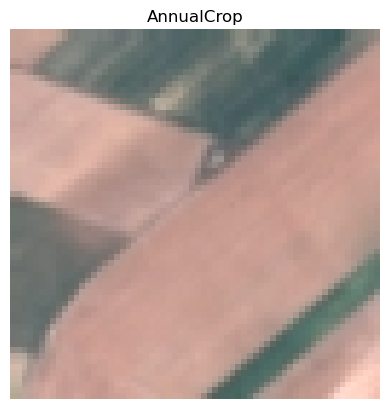

In [179]:

# pick one test image
idx = 0
img = x_test[idx]          # shape (64, 64, 3)
label = y_test[idx]

print("Label:", label)
plt.imshow(img)
plt.axis("off")
plt.title(decode_label(label))
plt.show()


In [180]:
def show_feature_maps(feature_maps, num_channels=6, title=""):
    # feature_maps: (1, H, W, C)
    fmap = feature_maps[0]  # (H, W, C)
    C = fmap.shape[-1]
    num_channels = min(num_channels, C)

    plt.figure(figsize=(12, 2))
    for i in range(num_channels):
        plt.subplot(1, num_channels, i+1)
        plt.imshow(fmap[:, :, i], cmap="gray")
        plt.axis("off")
        plt.title(f"ch {i+1}")
    # move the suptitle down a bit
    plt.suptitle(title, y=1.05)
    plt.show()

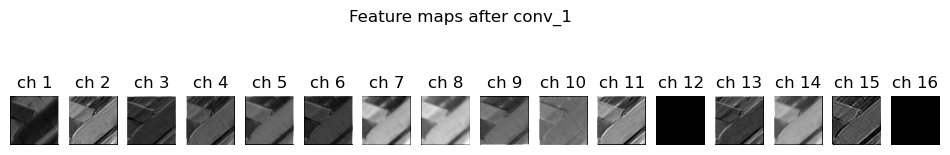

In [181]:
show_feature_maps(act_conv1, num_channels=16, title="Feature maps after conv_1")

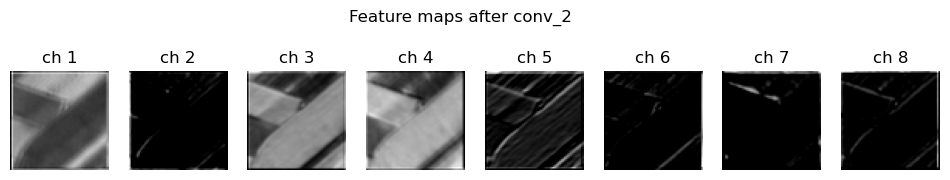

In [182]:
show_feature_maps(act_conv2, num_channels=8, title="Feature maps after conv_2")

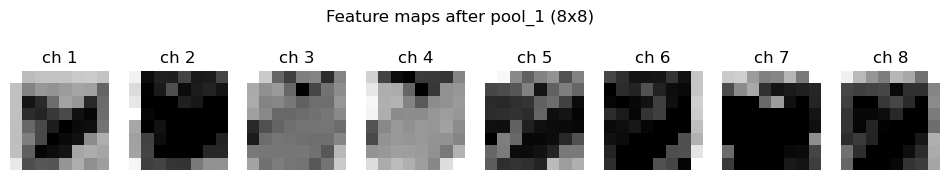

In [184]:
show_feature_maps(act_pool1, num_channels=8, title="Feature maps after pool_1 (8x8)")

In [185]:
def compute_saliency_map(model, image, class_index=None):
    """
    image: (H, W, 3), scaled to [0,1]
    Returns: saliency map (H, W) normalized to [0,1]
    """
    x = tf.convert_to_tensor(image[None, ...])  # (1, H, W, 3)

    with tf.GradientTape() as tape:
        tape.watch(x)
        preds = model(x)          # (1, num_classes)
        if class_index is None:
            class_index = tf.argmax(preds[0])
        score = preds[0, class_index]

    grads = tape.gradient(score, x)            # (1, H, W, 3)
    grads = tf.math.abs(grads)
    # max over color channels
    saliency = tf.reduce_max(grads, axis=-1)[0]  # (H, W)

    # normalize to [0,1]
    saliency_min = tf.reduce_min(saliency)
    saliency_max = tf.reduce_max(saliency)
    saliency_norm = (saliency - saliency_min) / (saliency_max - saliency_min + 1e-8)

    return saliency_norm.numpy(), int(class_index.numpy())

True label: AnnualCrop , Predicted label: AnnualCrop


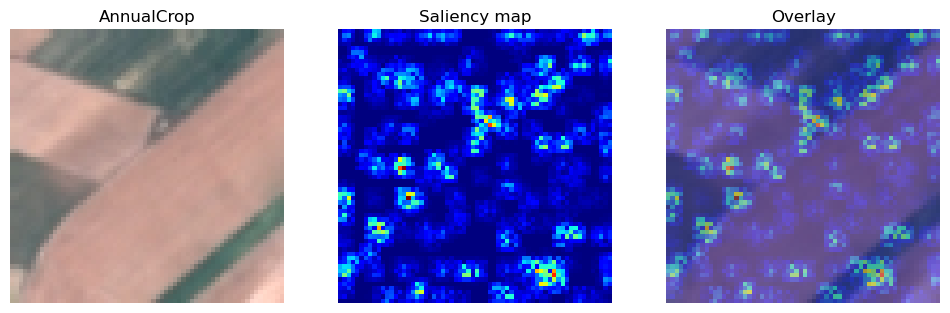

In [189]:
saliency, pred_class = compute_saliency_map(model, img)

print("True label:", decode_label(label), ", Predicted label:", decode_label(pred_class))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.axis("off")
plt.title(decode_label(label))

plt.subplot(1, 3, 2)
plt.imshow(saliency, cmap="jet")
plt.axis("off")
plt.title("Saliency map")

plt.subplot(1, 3, 3)
plt.imshow(img)
plt.imshow(saliency, cmap="jet", alpha=0.5)
plt.axis("off")
plt.title("Overlay")
plt.show()


# Load, from scratch, a model trained on the EuroSat dataset.

In your workspace, you will find another model trained on the `EuroSAT` dataset in `.h5` format. This model is trained on a larger subset of the EuroSAT dataset and has a more complex architecture. The path to the model is `models/EuroSatNet.h5`. See how its testing accuracy compares to your model!

In [72]:
#### GRADED CELL ####

import os
import tensorflow as tf

def get_model_eurosatnet():
    """
    This function should return the pretrained EuroSatNet.h5 model if available.
    If the file is not found locally (e.g., when running outside the course
    workspace), it falls back to a generic pretrained model so that the notebook
    still runs.
    """
    path = "models/EuroSatNet.h5"
    if os.path.exists(path):
        # Course / official environment
        model = tf.keras.models.load_model(path)
        return model
    else:
        # Fallback for local runs: build a simple pretrained model
        # (NOT EuroSatNet, just to avoid a crash).
        base = tf.keras.applications.MobileNetV2(
            input_shape=x_train.shape[1:],  # (64, 64, 3)
            include_top=False,
            weights="imagenet",
        )
        base.trainable = False

        inputs = tf.keras.Input(shape=x_train.shape[1:])
        x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
        x = base(x, training=False)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
        model = tf.keras.Model(inputs, outputs)
        model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )
        return model


In [74]:
model_eurosatnet = get_model_eurosatnet()

/tmp/ipykernel_24515/771116503.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(


In [75]:
model_eurosatnet.summary()

Model: "functional_127"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [76]:
get_test_accuracy(model_eurosatnet, x_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accuracy: 0.1333 - loss: 4.3953
accuracy: 0.133


Congratulations for completing this programming assignment! You're now ready to move on to the capstone project for this course.